In [15]:
#https://github.com/adventuresinML/adventures-in-ml-code/blob/master/keras_lstm.py
    
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np

# for scaling and inverse_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
from keras.models import load_model

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger

import pickle
from os import listdir

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	print(type(data))
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # range([start,] stop [, step])
        # DataFrame.shift(periods=1, freq=None, axis=0), returns DataFrame
		cols.append(df.shift(i)) 
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	# We are only interested in final bb after certain frames, e.g. 31st, 61st etc
	for i in range(n_out - 1 , n_out): #(n_out th element from the last element in the sequence)
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    #  concatenating along the columns (axis=1), a DataFrame is returned.
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	print(len(agg))
	return agg


%ls cm-pm | wc -l 185      *2  370
%ls cm-ps | wc -l 142 145  *3  335
%ls cms-pm | wc -l 245 245 *2  490
%ls cms-ps | wc -l 37 40   *12 480
%ls cs-pm| wc -l 173 175   *2  350
%ls cs-ps | wc -l 15 15    *30 450

In [16]:
train_split = ["%s" %f for f in listdir("./train")]
#print(train_csv)

In [17]:
#del reframed
n_seq = 30
n_seq_future = 30
n_features = 4

reframed = np.zeros( (1, (n_seq+1) * n_features))

In [18]:
(reframed[0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [19]:
train_dirs= {"cm-pm":2, "cm-ps":3, "cms-pm":2, "cms-ps":12, "cs-pm":2, "cs-ps":30}
for d in train_split:
    print (d)
    factor = train_dirs[d]
    print(factor)
    train_csv = ["%s" %("train/" + d +"/" +f) for f in listdir("train/" + d) * factor ]
    print(len(train_csv)   ) 

cm-ps
3
426
cs-ps
30
450
cm-pm
2
370
cs-pm
2
346
cms-ps
12
444
cms-pm
2
490


In [20]:
train_dirs= {"cm-pm":2, "cm-ps":3, "cms-pm":2, "cms-ps":12, "cs-pm":2, "cs-ps":30}

# specify the number of lag hours
#n_seq = 15
#n_seq_future = 30
#n_features = 4
np.array(reframed, dtype='float32')
# load dataset
#train_csv = ["train/0_184_1327b.csv", "train/0_184_1329b.csv"]

for d in train_split:
    print (d)
    factor = train_dirs[d]
    print(factor)
    train_csv = ["%s" %("train/" + d +"/" +f) for f in listdir("train/" + d) * factor ]
    print(len(train_csv)   ) 
    for f in train_csv:
        dataset = read_csv(f, header=0)
        values = dataset.values
        print(values.shape)

        # ensure all data is float
        values = values.astype('float32')

        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        #print(scaler.data_max_)
        #print(scaler.data_min_)

        # frame as supervised learning
        reframed = np.append(reframed, series_to_supervised(scaled, n_seq, n_seq_future), axis = 0)
        print(reframed.shape)
    
reframed = np.delete(reframed, 0, axis = 0)
print(reframed.shape)
# split into train and test sets
values = reframed
print(values.shape)
n_train_num = int(reframed.shape[0] * 0.8)
print(n_train_num)
train = values[:n_train_num, :]
val = values[n_train_num:, :]

# split into input and outputs
n_obs = n_seq * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:n_obs+n_features]
val_X, val_y = val[:, :n_obs], val[:, n_obs:n_obs+n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_seq, n_features))
val_X = val_X.reshape((val_X.shape[0], n_seq, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

cm-ps
3
426
(273, 4)
<class 'numpy.ndarray'>
214
(215, 124)
(152, 4)
<class 'numpy.ndarray'>
93
(308, 124)
(66, 4)
<class 'numpy.ndarray'>
7
(315, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(495, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(645, 124)
(136, 4)
<class 'numpy.ndarray'>
77
(722, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(872, 124)
(137, 4)
<class 'numpy.ndarray'>
78
(950, 124)
(103, 4)
<class 'numpy.ndarray'>
44
(994, 124)
(69, 4)
<class 'numpy.ndarray'>
10
(1004, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(1154, 124)
(200, 4)
<class 'numpy.ndarray'>
141
(1295, 124)
(38, 4)
<class 'numpy.ndarray'>
0
(1295, 124)
(197, 4)
<class 'numpy.ndarray'>
138
(1433, 124)
(321, 4)
<class 'numpy.ndarray'>
262
(1695, 124)
(214, 4)
<class 'numpy.ndarray'>
155
(1850, 124)
(250, 4)
<class 'numpy.ndarray'>
191
(2041, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(2221, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(2401, 124)
(269, 4)
<class 'numpy.ndarray'>
210
(2611, 124)
(344, 4)
<class 'numpy.ndarra

(25462, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(25612, 124)
(168, 4)
<class 'numpy.ndarray'>
109
(25721, 124)
(280, 4)
<class 'numpy.ndarray'>
221
(25942, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(26212, 124)
(277, 4)
<class 'numpy.ndarray'>
218
(26430, 124)
(224, 4)
<class 'numpy.ndarray'>
165
(26595, 124)
(264, 4)
<class 'numpy.ndarray'>
205
(26800, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(26950, 124)
(281, 4)
<class 'numpy.ndarray'>
222
(27172, 124)
(328, 4)
<class 'numpy.ndarray'>
269
(27441, 124)
(161, 4)
<class 'numpy.ndarray'>
102
(27543, 124)
(169, 4)
<class 'numpy.ndarray'>
110
(27653, 124)
(232, 4)
<class 'numpy.ndarray'>
173
(27826, 124)
(288, 4)
<class 'numpy.ndarray'>
229
(28055, 124)
(259, 4)
<class 'numpy.ndarray'>
200
(28255, 124)
(299, 4)
<class 'numpy.ndarray'>
240
(28495, 124)
(224, 4)
<class 'numpy.ndarray'>
165
(28660, 124)
(88, 4)
<class 'numpy.ndarray'>
29
(28689, 124)
(56, 4)
<class 'numpy.ndarray'>
0
(28689, 124)
(312, 4)
<class 'numpy.ndarray'>
253
(2894

(50523, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(50793, 124)
(111, 4)
<class 'numpy.ndarray'>
52
(50845, 124)
(25, 4)
<class 'numpy.ndarray'>
0
(50845, 124)
(359, 4)
<class 'numpy.ndarray'>
300
(51145, 124)
(469, 4)
<class 'numpy.ndarray'>
410
(51555, 124)
(90, 4)
<class 'numpy.ndarray'>
31
(51586, 124)
(88, 4)
<class 'numpy.ndarray'>
29
(51615, 124)
(76, 4)
<class 'numpy.ndarray'>
17
(51632, 124)
(75, 4)
<class 'numpy.ndarray'>
16
(51648, 124)
(230, 4)
<class 'numpy.ndarray'>
171
(51819, 124)
(319, 4)
<class 'numpy.ndarray'>
260
(52079, 124)
(252, 4)
<class 'numpy.ndarray'>
193
(52272, 124)
(244, 4)
<class 'numpy.ndarray'>
185
(52457, 124)
(276, 4)
<class 'numpy.ndarray'>
217
(52674, 124)
(218, 4)
<class 'numpy.ndarray'>
159
(52833, 124)
(49, 4)
<class 'numpy.ndarray'>
0
(52833, 124)
(311, 4)
<class 'numpy.ndarray'>
252
(53085, 124)
(201, 4)
<class 'numpy.ndarray'>
142
(53227, 124)
(71, 4)
<class 'numpy.ndarray'>
12
(53239, 124)
(233, 4)
<class 'numpy.ndarray'>
174
(53413, 124)
(104

(81836, 124)
(586, 4)
<class 'numpy.ndarray'>
527
(82363, 124)
(469, 4)
<class 'numpy.ndarray'>
410
(82773, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(82953, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(83103, 124)
(204, 4)
<class 'numpy.ndarray'>
145
(83248, 124)
(147, 4)
<class 'numpy.ndarray'>
88
(83336, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(83426, 124)
(579, 4)
<class 'numpy.ndarray'>
520
(83946, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(84036, 124)
(477, 4)
<class 'numpy.ndarray'>
418
(84454, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(84724, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(84874, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(85024, 124)
(344, 4)
<class 'numpy.ndarray'>
285
(85309, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(85399, 124)
(586, 4)
<class 'numpy.ndarray'>
527
(85926, 124)
(469, 4)
<class 'numpy.ndarray'>
410
(86336, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(86516, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(86666, 124)
(204, 4)
<class 'numpy.ndarray'>
145
(868

(120939, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(121029, 124)
(586, 4)
<class 'numpy.ndarray'>
527
(121556, 124)
(469, 4)
<class 'numpy.ndarray'>
410
(121966, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(122146, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(122296, 124)
(204, 4)
<class 'numpy.ndarray'>
145
(122441, 124)
(147, 4)
<class 'numpy.ndarray'>
88
(122529, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(122619, 124)
(579, 4)
<class 'numpy.ndarray'>
520
(123139, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(123229, 124)
(477, 4)
<class 'numpy.ndarray'>
418
(123647, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(123917, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(124067, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(124217, 124)
(344, 4)
<class 'numpy.ndarray'>
285
(124502, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(124592, 124)
(586, 4)
<class 'numpy.ndarray'>
527
(125119, 124)
(469, 4)
<class 'numpy.ndarray'>
410
(125529, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(125709, 124)
(209, 4)
<class 'numpy

(159697, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(159847, 124)
(344, 4)
<class 'numpy.ndarray'>
285
(160132, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(160222, 124)
(586, 4)
<class 'numpy.ndarray'>
527
(160749, 124)
(469, 4)
<class 'numpy.ndarray'>
410
(161159, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(161339, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(161489, 124)
(204, 4)
<class 'numpy.ndarray'>
145
(161634, 124)
(147, 4)
<class 'numpy.ndarray'>
88
(161722, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(161812, 124)
(579, 4)
<class 'numpy.ndarray'>
520
(162332, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(162422, 124)
(477, 4)
<class 'numpy.ndarray'>
418
(162840, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(163110, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(163260, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(163410, 124)
(344, 4)
<class 'numpy.ndarray'>
285
(163695, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(163785, 124)
(586, 4)
<class 'numpy.ndarray'>
527
(164312, 124)
(469, 4)
<class 'numpy

(185455, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(185545, 124)
(137, 4)
<class 'numpy.ndarray'>
78
(185623, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(185803, 124)
(119, 4)
<class 'numpy.ndarray'>
60
(185863, 124)
(193, 4)
<class 'numpy.ndarray'>
134
(185997, 124)
(230, 4)
<class 'numpy.ndarray'>
171
(186168, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(186348, 124)
(218, 4)
<class 'numpy.ndarray'>
159
(186507, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(186597, 124)
(579, 4)
<class 'numpy.ndarray'>
520
(187117, 124)
(119, 4)
<class 'numpy.ndarray'>
60
(187177, 124)
(253, 4)
<class 'numpy.ndarray'>
194
(187371, 124)
(101, 4)
<class 'numpy.ndarray'>
42
(187413, 124)
(179, 4)
<class 'numpy.ndarray'>
120
(187533, 124)
(307, 4)
<class 'numpy.ndarray'>
248
(187781, 124)
(229, 4)
<class 'numpy.ndarray'>
170
(187951, 124)
(299, 4)
<class 'numpy.ndarray'>
240
(188191, 124)
(87, 4)
<class 'numpy.ndarray'>
28
(188219, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(188369, 124)
(179, 4)
<class 'numpy.nd

(206919, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(207069, 124)
(215, 4)
<class 'numpy.ndarray'>
156
(207225, 124)
(115, 4)
<class 'numpy.ndarray'>
56
(207281, 124)
(119, 4)
<class 'numpy.ndarray'>
60
(207341, 124)
(117, 4)
<class 'numpy.ndarray'>
58
(207399, 124)
(188, 4)
<class 'numpy.ndarray'>
129
(207528, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(207708, 124)
(199, 4)
<class 'numpy.ndarray'>
140
(207848, 124)
(89, 4)
<class 'numpy.ndarray'>
30
(207878, 124)
(210, 4)
<class 'numpy.ndarray'>
151
(208029, 124)
(175, 4)
<class 'numpy.ndarray'>
116
(208145, 124)
(243, 4)
<class 'numpy.ndarray'>
184
(208329, 124)
(170, 4)
<class 'numpy.ndarray'>
111
(208440, 124)
(150, 4)
<class 'numpy.ndarray'>
91
(208531, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(208621, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(208711, 124)
(359, 4)
<class 'numpy.ndarray'>
300
(209011, 124)
(109, 4)
<class 'numpy.ndarray'>
50
(209061, 124)
(232, 4)
<class 'numpy.ndarray'>
173
(209234, 124)
(149, 4)
<class 'numpy.nda

(231373, 124)
(61, 4)
<class 'numpy.ndarray'>
2
(231375, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(231555, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(231645, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(231735, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(231915, 124)
(206, 4)
<class 'numpy.ndarray'>
147
(232062, 124)
(179, 4)
<class 'numpy.ndarray'>
120
(232182, 124)
(264, 4)
<class 'numpy.ndarray'>
205
(232387, 124)
(118, 4)
<class 'numpy.ndarray'>
59
(232446, 124)
(495, 4)
<class 'numpy.ndarray'>
436
(232882, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(233062, 124)
(169, 4)
<class 'numpy.ndarray'>
110
(233172, 124)
(296, 4)
<class 'numpy.ndarray'>
237
(233409, 124)
(258, 4)
<class 'numpy.ndarray'>
199
(233608, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(233878, 124)
(241, 4)
<class 'numpy.ndarray'>
182
(234060, 124)
(177, 4)
<class 'numpy.ndarray'>
118
(234178, 124)
(194, 4)
<class 'numpy.ndarray'>
135
(234313, 124)
(114, 4)
<class 'numpy.ndarray'>
55
(234368, 124)
(225, 4)
<class 'numpy.n

(258360, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(258630, 124)
(119, 4)
<class 'numpy.ndarray'>
60
(258690, 124)
(244, 4)
<class 'numpy.ndarray'>
185
(258875, 124)
(137, 4)
<class 'numpy.ndarray'>
78
(258953, 124)
(296, 4)
<class 'numpy.ndarray'>
237
(259190, 124)
(276, 4)
<class 'numpy.ndarray'>
217
(259407, 124)
(218, 4)
<class 'numpy.ndarray'>
159
(259566, 124)
(311, 4)
<class 'numpy.ndarray'>
252
(259818, 124)
(188, 4)
<class 'numpy.ndarray'>
129
(259947, 124)
(203, 4)
<class 'numpy.ndarray'>
144
(260091, 124)
(233, 4)
<class 'numpy.ndarray'>
174
(260265, 124)
(61, 4)
<class 'numpy.ndarray'>
2
(260267, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(260447, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(260537, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(260627, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(260807, 124)
(206, 4)
<class 'numpy.ndarray'>
147
(260954, 124)
(179, 4)
<class 'numpy.ndarray'>
120
(261074, 124)
(264, 4)
<class 'numpy.ndarray'>
205
(261279, 124)
(118, 4)
<class 'numpy.n

(284170, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(284350, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(284530, 124)
(227, 4)
<class 'numpy.ndarray'>
168
(284698, 124)
(389, 4)
<class 'numpy.ndarray'>
330
(285028, 124)
(118, 4)
<class 'numpy.ndarray'>
59
(285087, 124)
(106, 4)
<class 'numpy.ndarray'>
47
(285134, 124)
(147, 4)
<class 'numpy.ndarray'>
88
(285222, 124)
(72, 4)
<class 'numpy.ndarray'>
13
(285235, 124)
(75, 4)
<class 'numpy.ndarray'>
16
(285251, 124)
(92, 4)
<class 'numpy.ndarray'>
33
(285284, 124)
(241, 4)
<class 'numpy.ndarray'>
182
(285466, 124)
(154, 4)
<class 'numpy.ndarray'>
95
(285561, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(285651, 124)
(369, 4)
<class 'numpy.ndarray'>
310
(285961, 124)
(287, 4)
<class 'numpy.ndarray'>
228
(286189, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(286279, 124)
(127, 4)
<class 'numpy.ndarray'>
68
(286347, 124)
(477, 4)
<class 'numpy.ndarray'>
418
(286765, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(287035, 124)
(346, 4)
<class 'numpy.ndarray

(149, 4)
<class 'numpy.ndarray'>
90
(309467, 124)
(127, 4)
<class 'numpy.ndarray'>
68
(309535, 124)
(477, 4)
<class 'numpy.ndarray'>
418
(309953, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(310223, 124)
(346, 4)
<class 'numpy.ndarray'>
287
(310510, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(310600, 124)
(119, 4)
<class 'numpy.ndarray'>
60
(310660, 124)
(330, 4)
<class 'numpy.ndarray'>
271
(310931, 124)
(136, 4)
<class 'numpy.ndarray'>
77
(311008, 124)
(132, 4)
<class 'numpy.ndarray'>
73
(311081, 124)
(344, 4)
<class 'numpy.ndarray'>
285
(311366, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(311546, 124)
(269, 4)
<class 'numpy.ndarray'>
210
(311756, 124)
(176, 4)
<class 'numpy.ndarray'>
117
(311873, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(311963, 124)
(120, 4)
<class 'numpy.ndarray'>
61
(312024, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(312114, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(312384, 124)
(175, 4)
<class 'numpy.ndarray'>
116
(312500, 124)
(192, 4)
<class 'numpy.ndarray'>
133
(31

(335151, 124)
(120, 4)
<class 'numpy.ndarray'>
61
(335212, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(335302, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(335572, 124)
(175, 4)
<class 'numpy.ndarray'>
116
(335688, 124)
(192, 4)
<class 'numpy.ndarray'>
133
(335821, 124)
(469, 4)
<class 'numpy.ndarray'>
410
(336231, 124)
(171, 4)
<class 'numpy.ndarray'>
112
(336343, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(336523, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(336703, 124)
(227, 4)
<class 'numpy.ndarray'>
168
(336871, 124)
(389, 4)
<class 'numpy.ndarray'>
330
(337201, 124)
(118, 4)
<class 'numpy.ndarray'>
59
(337260, 124)
(106, 4)
<class 'numpy.ndarray'>
47
(337307, 124)
(147, 4)
<class 'numpy.ndarray'>
88
(337395, 124)
(72, 4)
<class 'numpy.ndarray'>
13
(337408, 124)
(75, 4)
<class 'numpy.ndarray'>
16
(337424, 124)
(92, 4)
<class 'numpy.ndarray'>
33
(337457, 124)
(241, 4)
<class 'numpy.ndarray'>
182
(337639, 124)
(154, 4)
<class 'numpy.ndarray'>
95
(337734, 124)
(149, 4)
<class 'numpy.ndarra

(362938, 124)
(233, 4)
<class 'numpy.ndarray'>
174
(363112, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(363292, 124)
(203, 4)
<class 'numpy.ndarray'>
144
(363436, 124)
(329, 4)
<class 'numpy.ndarray'>
270
(363706, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(363796, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(363886, 124)
(160, 4)
<class 'numpy.ndarray'>
101
(363987, 124)
(174, 4)
<class 'numpy.ndarray'>
115
(364102, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(364192, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(364282, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(364372, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(364552, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(364732, 124)
(281, 4)
<class 'numpy.ndarray'>
222
(364954, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(365104, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(365254, 124)
(269, 4)
<class 'numpy.ndarray'>
210
(365464, 124)
(264, 4)
<class 'numpy.ndarray'>
205
(365669, 124)
(231, 4)
<class 'numpy.ndarray'>
172
(365841, 124)
(182, 4)
<class 'numpy

(389243, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(389393, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(389573, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(389723, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(389873, 124)
(200, 4)
<class 'numpy.ndarray'>
141
(390014, 124)
(358, 4)
<class 'numpy.ndarray'>
299
(390313, 124)
(130, 4)
<class 'numpy.ndarray'>
71
(390384, 124)
(216, 4)
<class 'numpy.ndarray'>
157
(390541, 124)
(269, 4)
<class 'numpy.ndarray'>
210
(390751, 124)
(321, 4)
<class 'numpy.ndarray'>
262
(391013, 124)
(289, 4)
<class 'numpy.ndarray'>
230
(391243, 124)
(299, 4)
<class 'numpy.ndarray'>
240
(391483, 124)
(232, 4)
<class 'numpy.ndarray'>
173
(391656, 124)
(256, 4)
<class 'numpy.ndarray'>
197
(391853, 124)
(84, 4)
<class 'numpy.ndarray'>
25
(391878, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(392058, 124)
(74, 4)
<class 'numpy.ndarray'>
15
(392073, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(392253, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(392433, 124)
(269, 4)
<class 'numpy

(416772, 124)
(218, 4)
<class 'numpy.ndarray'>
159
(416931, 124)
(119, 4)
<class 'numpy.ndarray'>
60
(416991, 124)
(239, 4)
<class 'numpy.ndarray'>
180
(417171, 124)
(579, 4)
<class 'numpy.ndarray'>
520
(417691, 124)
(153, 4)
<class 'numpy.ndarray'>
94
(417785, 124)
(143, 4)
<class 'numpy.ndarray'>
84
(417869, 124)
(151, 4)
<class 'numpy.ndarray'>
92
(417961, 124)
(368, 4)
<class 'numpy.ndarray'>
309
(418270, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(418360, 124)
(133, 4)
<class 'numpy.ndarray'>
74
(418434, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(418524, 124)
(232, 4)
<class 'numpy.ndarray'>
173
(418697, 124)
(253, 4)
<class 'numpy.ndarray'>
194
(418891, 124)
(491, 4)
<class 'numpy.ndarray'>
432
(419323, 124)
(179, 4)
<class 'numpy.ndarray'>
120
(419443, 124)
(179, 4)
<class 'numpy.ndarray'>
120
(419563, 124)
(149, 4)
<class 'numpy.ndarray'>
90
(419653, 124)
(307, 4)
<class 'numpy.ndarray'>
248
(419901, 124)
(209, 4)
<class 'numpy.ndarray'>
150
(420051, 124)
(229, 4)
<class 'numpy.nd

In [21]:
(train_X[0])

array([[0.07309183, 0.89024401, 0.04956463, 0.        ],
       [0.07244501, 0.90243912, 0.04822505, 0.01754379],
       [0.07244501, 0.90243912, 0.04688546, 0.02339172],
       [0.07179818, 0.90243912, 0.04554588, 0.03508759],
       [0.07050452, 0.91463423, 0.04487607, 0.04678345],
       [0.06921086, 0.92682934, 0.04420629, 0.05847931],
       [0.06727037, 0.92682934, 0.04353648, 0.05847931],
       [0.06597671, 0.93902445, 0.04286671, 0.07017565],
       [0.06468305, 0.95121956, 0.0421969 , 0.08187151],
       [0.06274256, 0.95121956, 0.0421969 , 0.08187151],
       [0.06080207, 0.95121956, 0.0421969 , 0.08771944],
       [0.05886158, 0.93902445, 0.04152712, 0.08187151],
       [0.05692109, 0.93902445, 0.04152712, 0.08771944],
       [0.05498058, 0.93902445, 0.04152712, 0.08771944],
       [0.05368692, 0.93902445, 0.03951773, 0.0994153 ],
       [0.05174643, 0.93902445, 0.03683856, 0.10526323],
       [0.05045277, 0.93902445, 0.03549898, 0.1169591 ],
       [0.04851228, 0.93902445,

In [22]:
train_y[0]

array([0.00258732, 0.8780489 , 0.01004687, 0.50292397])

In [23]:
reframed.shape[0]

427669

In [24]:
print(reframed.shape)

(427669, 124)


In [25]:
train_X.shape

(342135, 30, 4)

In [26]:
val_X.shape

(85534, 30, 4)

In [27]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath='conf10_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='bb_lstm_training_log.csv',
                       separator=',',
                       append=True)

#early_stopping = EarlyStopping(monitor='val_loss',
#                               min_delta=0.0,
#                               patience=20,
#                               verbose=1)

#reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
#                                         factor=0.2,
#                                         patience=8,
#                                         verbose=1,
#                                         epsilon=0.001,
#                                         cooldown=0,
#                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             csv_logger
#             early_stopping
             #reduce_learning_rate]
            ]

In [28]:
 # design network
K.clear_session()  # Clear previous models from memory.    
model = Sequential()

model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))

#model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.1))
          
#model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.1))

#model.add(LSTM(units=50))
#model.add(Dropout(0.1))          

model.add(Dense(4))
#adam = optimizers.Adam(lr=0.01, decay=0.0001)
model.compile(loss='mae', optimizer="adam")
#A loss function or objective function, or optimization score function
#mean_absolute_error

epochs = 300
# fit network
history = model.fit(train_X, train_y, 
                    epochs=epochs, 
                    batch_size=72,
                    validation_data=(val_X, val_y), 
                    verbose=2,
                    callbacks=callbacks,
                    shuffle=False)

Train on 342135 samples, validate on 85534 samples
Epoch 1/300


InternalError: GPU sync failed

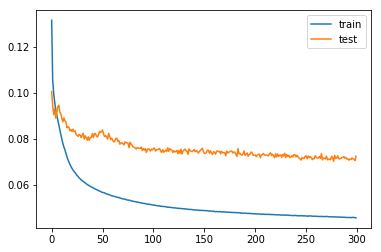

In [16]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig("conf10_300e_30ffuture.png")
pyplot.show()


In [17]:
# save the model
model.save("conf9_300e_30ffuture-model.h5")

In [10]:
# load test dataset
values = read_csv('bb-cross-test1.csv', header=0).values
print(len(values))
# ensure all data is float
values = values.astype('float32')

# normalize features

scaled = scaler.transform(values)
print(scaler.data_max_)
print(scaler.data_min_)

# specify the number of lag hours
#n_seq = 15
#n_features = 4

# frame as supervised learning
reframed = series_to_supervised(scaled, n_seq, 1)
print(reframed.shape)
values = reframed.values

# split into input and outputs
n_obs = n_seq * n_features
test_X, test_y = values[:, :n_obs], values[:, n_obs:n_obs+n_features]
print(test_X.shape, len(test_X), test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], n_seq, n_features))
print(test_X.shape, test_y.shape)

204
[1900.  953. 1919. 1079.]
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
(173, 124)
(173, 120) 173 (173, 4)
(173, 30, 4) (173, 4)


In [23]:
K.clear_session()  # Clear previous models from memory.    
model = load_model("30f_future-model.h5")
# make a prediction
yhat = model.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'test_X' is not defined

In [12]:
K.clear_session()  # Clear previous models from memory.  

In [14]:
test_X.shape

(173, 30, 4)

In [15]:
test_X[0]

array([[0.3368421 , 0.70094436, 0.34601355, 0.67191845],
       [0.33631578, 0.6977964 , 0.34549242, 0.67099166],
       [0.33631578, 0.6956978 , 0.34549242, 0.67006487],
       [0.33578947, 0.6935991 , 0.34497133, 0.6691381 ],
       [0.33578947, 0.6925498 , 0.34445024, 0.6691381 ],
       [0.33526313, 0.6915005 , 0.3439291 , 0.6691381 ],
       [0.33526313, 0.6915005 , 0.3439291 , 0.6691381 ],
       [0.33473682, 0.6956978 , 0.34340802, 0.6691381 ],
       [0.33473682, 0.699895  , 0.34340802, 0.67099166],
       [0.33421052, 0.703043  , 0.3428869 , 0.67191845],
       [0.33421052, 0.70619094, 0.3428869 , 0.67284524],
       [0.3336842 , 0.70828956, 0.3423658 , 0.67469877],
       [0.3336842 , 0.7093389 , 0.3418447 , 0.67562556],
       [0.33315787, 0.7103882 , 0.34132358, 0.67840594],
       [0.33263156, 0.7114375 , 0.3408025 , 0.68118626],
       [0.33263156, 0.7114375 , 0.3408025 , 0.68211305],
       [0.33263156, 0.7114375 , 0.3408025 , 0.68211305],
       [0.33263156, 0.7114375 ,

In [16]:
yhat.shape

(173, 4)

In [17]:
import numpy as np
yhat =  model.predict(np.expand_dims(test_X[0], axis=0))

In [18]:
inv_yhat = scaler.inverse_transform(yhat)

In [19]:
inv_yhat

array([[628.5579 , 675.93713, 668.5027 , 737.423  ]], dtype=float32)

In [1]:
del model
gc.collect()
del history

NameError: name 'model' is not defined

In [12]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [13]:
reset_keras()

NameError: name 'gc' is not defined